# LSGAN MNIST

This notebook is for implementing `Least Squares Generative Adversarial Networks (LSGAN)` from the paper [Least Squares Generative Adversarial Networks](https://arxiv.org/abs/1611.04076) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Parameters


In [3]:
img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

gpu_fraction = 0.3 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [7*7*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)
    
    # get loss (LSGAN)
    ########################################### LSGAN ###########################################
    d_loss = tf.reduce_mean(tf.square(D_logit_real-1)) + tf.reduce_mean(tf.square(D_logit_fake))
    g_loss = tf.reduce_mean(tf.square(D_logit_fake-1))
    #############################################################################################
    
    return d_loss, g_loss , G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Train

Epoch: 1 / G Loss: 1.16529 / D Loss: 0.03153


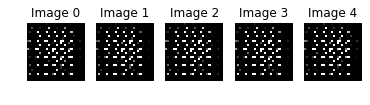

Epoch: 2 / G Loss: 0.93867 / D Loss: 0.01897
Epoch: 3 / G Loss: 0.98852 / D Loss: 0.13377
Epoch: 4 / G Loss: 1.11253 / D Loss: 0.09127
Epoch: 5 / G Loss: 1.21264 / D Loss: 0.15079


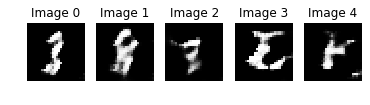

Epoch: 6 / G Loss: 0.49315 / D Loss: 0.18410
Epoch: 7 / G Loss: 0.90248 / D Loss: 0.13175
Epoch: 8 / G Loss: 0.90078 / D Loss: 0.12266
Epoch: 9 / G Loss: 1.01937 / D Loss: 0.11503
Epoch: 10 / G Loss: 0.42919 / D Loss: 0.15157


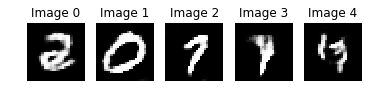

Epoch: 11 / G Loss: 0.84066 / D Loss: 0.16259
Epoch: 12 / G Loss: 0.96826 / D Loss: 0.15540
Epoch: 13 / G Loss: 0.56044 / D Loss: 0.22127
Epoch: 14 / G Loss: 1.41663 / D Loss: 0.15017
Epoch: 15 / G Loss: 0.70713 / D Loss: 0.14754


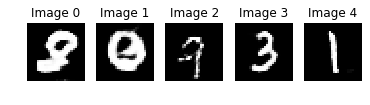

Epoch: 16 / G Loss: 1.08319 / D Loss: 0.19816
Epoch: 17 / G Loss: 0.83252 / D Loss: 0.20349
Epoch: 18 / G Loss: 0.51215 / D Loss: 0.31056
Epoch: 19 / G Loss: 0.67321 / D Loss: 0.27336
Epoch: 20 / G Loss: 0.46792 / D Loss: 0.34625


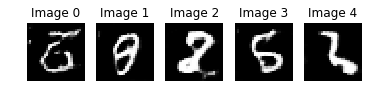

Epoch: 21 / G Loss: 0.98783 / D Loss: 0.10422
Epoch: 22 / G Loss: 0.74340 / D Loss: 0.27469
Epoch: 23 / G Loss: 0.38555 / D Loss: 0.53694
Epoch: 24 / G Loss: 0.49317 / D Loss: 0.44918
Epoch: 25 / G Loss: 0.46167 / D Loss: 0.24395


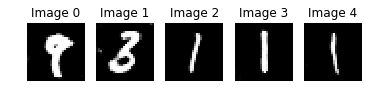

Epoch: 26 / G Loss: 0.98755 / D Loss: 0.15575
Epoch: 27 / G Loss: 0.66532 / D Loss: 0.21331
Epoch: 28 / G Loss: 0.34536 / D Loss: 0.32381
Epoch: 29 / G Loss: 0.57491 / D Loss: 0.36089
Epoch: 30 / G Loss: 0.31670 / D Loss: 0.39188


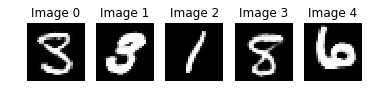

Epoch: 31 / G Loss: 0.62452 / D Loss: 0.14048
Epoch: 32 / G Loss: 0.80509 / D Loss: 0.19184
Epoch: 33 / G Loss: 0.63966 / D Loss: 0.23758
Epoch: 34 / G Loss: 0.65199 / D Loss: 0.26047
Epoch: 35 / G Loss: 0.60702 / D Loss: 0.40129


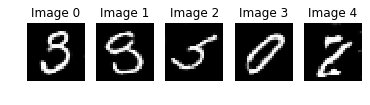

Epoch: 36 / G Loss: 0.82357 / D Loss: 0.21337
Epoch: 37 / G Loss: 0.51332 / D Loss: 0.21721
Epoch: 38 / G Loss: 0.55631 / D Loss: 0.23861
Epoch: 39 / G Loss: 0.85094 / D Loss: 0.23093
Epoch: 40 / G Loss: 0.87734 / D Loss: 0.29812


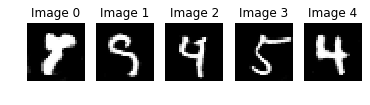

Epoch: 41 / G Loss: 0.73498 / D Loss: 0.17396
Epoch: 42 / G Loss: 0.55253 / D Loss: 0.26190
Epoch: 43 / G Loss: 0.99570 / D Loss: 0.21764
Epoch: 44 / G Loss: 0.64505 / D Loss: 0.24912
Epoch: 45 / G Loss: 0.82812 / D Loss: 0.25361


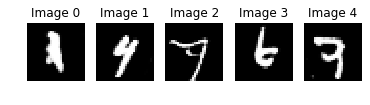

Epoch: 46 / G Loss: 0.66959 / D Loss: 0.30085
Epoch: 47 / G Loss: 0.55137 / D Loss: 0.17585
Epoch: 48 / G Loss: 0.82096 / D Loss: 0.30081
Epoch: 49 / G Loss: 0.62501 / D Loss: 0.23463
Epoch: 50 / G Loss: 0.86302 / D Loss: 0.22582


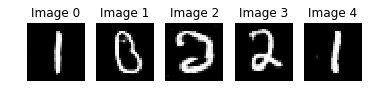

In [11]:
# Training
data_x = x_train
len_data = x_train.shape[0]

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(data_x)
      
    # Making mini-batch
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
        
        data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))
        
        sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))
        
        # Run Optimizer!
        G_out = sess.run(G, feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

        _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
        _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

        print("Batch: {} / {}".format(j, len_data), end="\r")
        
    # Print Progess
    print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))
    
    # Show test images 
    z_test = np.random.uniform(-1, 1, size=(5, n_latent))
    G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})
        
    if i == 0 or (i+1) % show_result_epoch == 0:
        f, ax = plt.subplots(1,5)
        for j in range(5):
            ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
            ax[j].axis('off')
            ax[j].set_title('Image '+str(j))

    plt.show()

## Image Generation

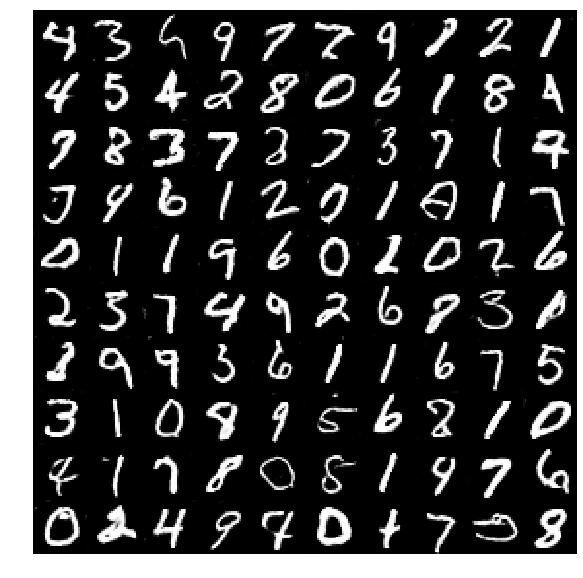

In [12]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()